In [11]:
import numpy as np
import matplotlib.pyplot as plt

#### Objective Functions

In [12]:
def rosenbrock(X):
    """
    Rosenbrock function.
    Global minimum: f(x) = 0 at x = [1, 1]
    """
    return sum(100.0 * (X[i + 1] - X[i] ** 2) ** 2 + (1 - X[i]) ** 2 for i in range(len(X) - 1))

def griewank(X):
    """
    Griewank function.
    Global minimum: f(x) = 0 at x = [0, 0]
    """
    X = np.array(X)
    i = np.arange(1, len(X) + 1)
    sum_term = np.sum(X ** 2) / 4000
    prod_term = np.prod(np.cos(X / np.sqrt(i)))
    return sum_term - prod_term + 1

#### Particle Class

In [13]:
class Particle:

    def __init__(self, dim, xmin, xmax, vmin, vmax, objective):
        """
        Constructor for the Particle class.
        Initializes the particle's position, velocity, and p_best position.
        """
        self.dim = dim
        self.position = np.random.uniform(xmin, xmax, dim)
        self.velocity = np.random.uniform(vmin, vmax, dim)

        self.best_position = np.copy(self.position)
        
        self.objective = objective
        self.best_fitness = self.fitness()

    def fitness(self):
        """
        Evaluates the fitness of a particle's position.
        """
        return self.objective(self.position)

    def update_velocity(self, global_best, w, c1, c2, vmin, vmax):
        """
        Updates the particle's velocity based on p_best and g_best positions.
        """
        r1 = np.random.rand(self.dim)
        r2 = np.random.rand(self.dim)

        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best - self.position)
        self.velocity = w * self.velocity + cognitive + social

        self.velocity = np.clip(self.velocity, vmin, vmax)

    def update_position(self, xmin, xmax):
        """
        Updates the particle's position and clips within bounds.
        """
        self.position += self.velocity
        self.position = np.clip(self.position, xmin, xmax)

    def update_personal_best(self):
        """
        Updates the particle's personal best position and fitness.
        """
        current_fitness = self.fitness()
        if current_fitness < self.best_fitness:
            self.best_position = np.copy(self.position)
            self.best_fitness = current_fitness

#### Particle Swarm Optimization Class

In [14]:
class PSO:

    def __init__(self, num_particles, dim, objective_fn, xmin, xmax, vmin, vmax, w=0.7, c1=0.5, c2=0.5, max_iter=1000):
        """
        Constructor for the PSO class.
        Initializes the PSO parameters and creates particles.
        """
        self.dim = dim
        self.num_particles = num_particles 
        self.objective_fn = objective_fn
        self.xmin = xmin
        self.xmax = xmax
        self.vmin = vmin
        self.vmax = vmax 
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter

        # initialize particles
        self.particles = [Particle(dim, xmin, xmax, vmin, vmax, objective_fn) for _ in range(num_particles)]
        self.global_best = self.get_global_best()

    def get_global_best(self):
        """
        Finds the global best particle from the swarm.
        """
        best_particle = min(self.particles, key=lambda p: p.best_fitness)
        return np.copy(best_particle.best_position), best_particle.best_fitness

    def optimize(self):
        """
        Main PSO optimization loop.
        """
        # list for storing the best fitness values for plotting
        best_fitness_values = []
        avg_fitness_values = []

        for _ in range(self.max_iter): # 1st stopping condition is max_iter

            for particle in self.particles:
                particle.update_velocity(self.global_best[0], self.w, self.c1, self.c2,
                                         self.vmin, self.vmax)
                particle.update_position(self.xmin, self.xmax)
                particle.update_personal_best()

            # Update global best after all particles are updated
            self.global_best = self.get_global_best()
            
            # Store the best and average fitness values for plotting
            best_fitness_values.append(self.global_best[1])
            avg_fitness = np.mean([p.best_fitness for p in self.particles])
            avg_fitness_values.append(avg_fitness)

            # Print the average and global best fitness for this iteration
            print(f"Iteration {_ + 1}/{self.max_iter}")
            print(f"Best fitness: {self.global_best[1]}")
            print(f"Average fitness: {avg_fitness}\n")

            # 2nd stopping condition: Check for convergence, if the best fitness doesn't change significantly
            # if len(best_fitness_values) > 1 and abs(best_fitness_values[-1] - best_fitness_values[-2]) < 1e-6: # 1e-6 small number
            #     print("Converged.")
            #     break

        return self.global_best, best_fitness_values, avg_fitness_values

#### Main

In [15]:
def plot_results(best_fitness_values, avg_fitness_values, objective):
    """
    Plot the best and average fitness values over iterations.
    """
    plt.plot(best_fitness_values, label='Best Fitness')
    plt.plot(avg_fitness_values, label='Average Fitness')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness Value')
    plt.title(f'PSO Optimization Results: {objective}')
    plt.legend()
    plt.grid()
    plt.show()

def run_griewank(dim, max_iter, num_particles, w, c1, c2):
    """
    Run PSO optimization for the Griewank function.
    """
    xmin, xmax = -30, 30
    vmin, vmax = -30, 30
    return PSO(num_particles, dim, griewank, xmin, xmax, vmin, vmax, w=w, c1=c1, c2=c2, max_iter=max_iter)

def run_rosenbrock(dim, max_iter, num_particles, w, c1, c2):
    """
    Run PSO optimization for the Rosenbrock function.
    """
    xmin, xmax = -2, 2
    vmin, vmax = -1, 3
    return PSO(num_particles, dim, rosenbrock, xmin, xmax, vmin, vmax, w=w, c1=c1, c2=c2, max_iter=max_iter)

# choose the objective function

# objective = input("Choose the objective function (griewank/rosenbrock): ").strip().lower()
# if objective == "griewank" or objective == "g":
#     objective = griewank
# elif objective == "rosenbrock" or objective == "r": 
#     objective = rosenbrock
# else:
#     raise ValueError("Invalid objective function. Choose 'griewank' or 'rosenbrock'.")

# setup

dim = 2
max_iter = 300
num_particles = 100
w = 0.2
c1 = 0.9
c2 = 0.1

#### Griewank Function Optimization

Iteration 1/300
Best fitness: 0.04901952187007852
Average fitness: 0.8748909046651505

Iteration 2/300
Best fitness: 0.04901952187007852
Average fitness: 0.7626489032825637

Iteration 3/300
Best fitness: 0.04896190184438631
Average fitness: 0.6703591003071264

Iteration 4/300
Best fitness: 0.04896190184438631
Average fitness: 0.6123603265439646

Iteration 5/300
Best fitness: 0.04896190184438631
Average fitness: 0.5865022428669099

Iteration 6/300
Best fitness: 0.04896190184438631
Average fitness: 0.5523145442710543

Iteration 7/300
Best fitness: 0.04896190184438631
Average fitness: 0.531429699949307

Iteration 8/300
Best fitness: 0.04896190184438631
Average fitness: 0.5261613173832362

Iteration 9/300
Best fitness: 0.04896190184438631
Average fitness: 0.5235156890575131

Iteration 10/300
Best fitness: 0.048948493608425125
Average fitness: 0.5226291095766142

Iteration 11/300
Best fitness: 0.04894322798793027
Average fitness: 0.5197493281580465

Iteration 12/300
Best fitness: 0.04894221

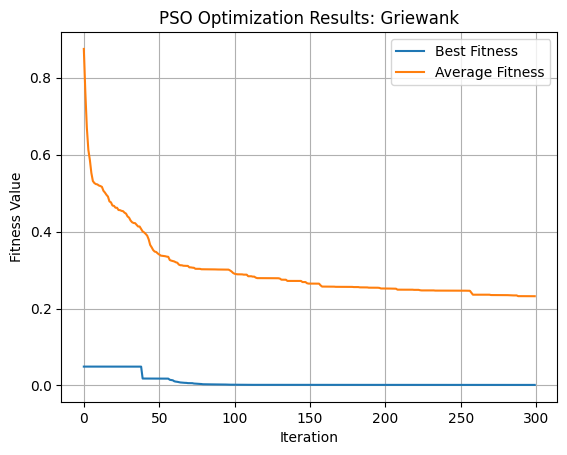

In [19]:
# list for plotting
best_fitness_values = []
avg_fitness_values = []

# run PSO optimization
pso = run_griewank(dim, max_iter, num_particles, w, c1, c2)
(best_position, best_fitness), best_fitness_values, avg_fitness_values = pso.optimize()

# results
print("Best solution found:", best_position)
print("Best fitness value:", best_fitness)

# validation of the global minimum
print("Function value at global minimum [0, 0]:", griewank([0, 0]))

plot_results(best_fitness_values, avg_fitness_values, "Griewank")

#### Rosenbrock Function Optimization

Iteration 1/300
Best fitness: 0.05487651945049192
Average fitness: 232.26385360458957

Iteration 2/300
Best fitness: 0.006727068124301871
Average fitness: 186.46430839048688

Iteration 3/300
Best fitness: 0.006727068124301871
Average fitness: 151.28107435770372

Iteration 4/300
Best fitness: 0.0038603318087940823
Average fitness: 123.21664227611568

Iteration 5/300
Best fitness: 0.0038603318087940823
Average fitness: 102.59965273651511

Iteration 6/300
Best fitness: 0.0038603318087940823
Average fitness: 87.82657782096308

Iteration 7/300
Best fitness: 0.002696199350562572
Average fitness: 76.06241022495878

Iteration 8/300
Best fitness: 0.0024134475741198385
Average fitness: 66.14083735749252

Iteration 9/300
Best fitness: 0.001845425071195083
Average fitness: 57.725787301973625

Iteration 10/300
Best fitness: 0.0013348828741298708
Average fitness: 50.62726687741158

Iteration 11/300
Best fitness: 0.0012465714732053026
Average fitness: 44.675487574394054

Iteration 12/300
Best fitness

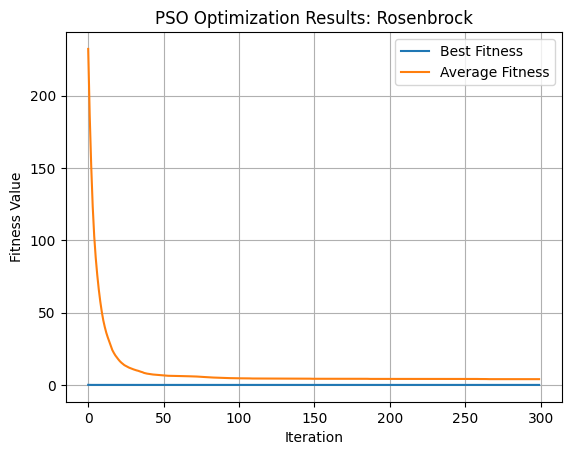

In [17]:
# list for plotting
best_fitness_values = []
avg_fitness_values = []

# run PSO optimization
pso = run_rosenbrock(dim, max_iter, num_particles, w, c1, c2)
(best_position, best_fitness), best_fitness_values, avg_fitness_values = pso.optimize()

# results
print("Best solution found:", best_position)
print("Best fitness value:", best_fitness)

# validation of the global minimum
print("Function value at global minimum [1, 1]:", rosenbrock([1, 1]))

plot_results(best_fitness_values, avg_fitness_values, "Rosenbrock")